In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datathon-2025/sample_submission.csv
/kaggle/input/datathon-2025/train.csv
/kaggle/input/datathon-2025/test.csv


In [25]:
import pandas as pd

# Load datasets
train = pd.read_csv("/kaggle/input/datathon-2025/train.csv")
test = pd.read_csv("/kaggle/input/datathon-2025/test.csv")
sample_submission = pd.read_csv("/kaggle/input/datathon-2025/sample_submission.csv")

# Check dataset shapes
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Sample submission shape:", sample_submission.shape)

# Display first rows
display(train.head())
display(test.head())
display(sample_submission.head())

# Check missing values
print("\nMissing values in train:")
print(train.isnull().sum())

print("\nMissing values in test:")
print(test.isnull().sum())

# Check column types
print("\nTrain columns:")
print(train.dtypes)

Train shape: (141219, 7)
Test shape: (62951, 6)
Sample submission shape: (30789, 2)


,event_time,event_type,product_id,category_id,user_id,user_session,session_value
0,2025-06-19 10:23:07+00:00,ADD_CART,PROD_011223,CAT_00054,USER_097562,SESSION_158779,90.29
1,2025-06-07 21:34:45+00:00,ADD_CART,PROD_005519,CAT_00144,USER_006535,SESSION_029987,16.39
2,2025-06-21 21:29:09+00:00,ADD_CART,PROD_000577,CAT_00273,USER_047199,SESSION_022134,64.27
3,2025-06-09 09:10:20+00:00,ADD_CART,PROD_019235,CAT_00442,USER_082028,SESSION_161308,41.67
4,2025-06-19 11:13:58+00:00,ADD_CART,PROD_001702,CAT_00025,USER_096574,SESSION_182859,86.11


,event_time,event_type,product_id,category_id,user_id,user_session
0,2025-06-28 10:09:58+00:00,ADD_CART,PROD_015000,CAT_00019,USER_109759,SESSION_164059
1,2025-06-25 11:57:50+00:00,ADD_CART,PROD_023887,CAT_00010,USER_010614,SESSION_109583
2,2025-06-30 14:34:20+00:00,ADD_CART,PROD_022673,CAT_00090,USER_041338,SESSION_171382
3,2025-06-30 22:12:18+00:00,ADD_CART,PROD_004664,CAT_00280,USER_015376,SESSION_137110
4,2025-06-26 16:55:18+00:00,ADD_CART,PROD_027815,CAT_00027,USER_054449,SESSION_146503


,user_session,session_value
0,SESSION_164059,0.0
1,SESSION_109583,0.0
2,SESSION_171382,0.0
3,SESSION_137110,0.0
4,SESSION_146503,0.0



Missing values in train:
event_time       0
event_type       0
product_id       0
category_id      0
user_id          0
user_session     0
session_value    0
dtype: int64

Missing values in test:
event_time      0
event_type      0
product_id      0
category_id     0
user_id         0
user_session    0
dtype: int64

Train columns:
event_time        object
event_type        object
product_id        object
category_id       object
user_id           object
user_session      object
session_value    float64
dtype: object


In [26]:
import pandas as pd
import numpy as np

# Copy train to avoid modifying the original
df = train.copy()

# Convert event_time to datetime
df["event_time"] = pd.to_datetime(df["event_time"])

# Aggregate by session
session_features = df.groupby("user_session").agg(
    session_start=("event_time", "min"),
    session_end=("event_time", "max"),
    session_length=("event_time", lambda x: (x.max() - x.min()).total_seconds()),
    event_count=("event_type", "count"),
    unique_event_types=("event_type", pd.Series.nunique),
    unique_products=("product_id", pd.Series.nunique),
    unique_categories=("category_id", pd.Series.nunique),
    unique_users=("user_id", pd.Series.nunique)
).reset_index()

# Merge target values
session_data = session_features.merge(
    train[["user_session", "session_value"]].drop_duplicates(),
    on="user_session",
    how="left"
)

# Check result
print("Session-level dataset shape:", session_data.shape)
display(session_data.head())

Session-level dataset shape: (70736, 10)


,user_session,session_start,session_end,session_length,event_count,unique_event_types,unique_products,unique_categories,unique_users,session_value
0,SESSION_000000,2025-06-02 12:14:45+00:00,2025-06-20 17:17:32+00:00,1573367.0,28,2,24,20,21,355.80
1,SESSION_000001,2025-06-02 03:55:52+00:00,2025-06-02 06:06:10+00:00,7818.0,6,4,5,5,1,96.60
2,SESSION_000004,2025-06-04 10:27:59+00:00,2025-06-04 10:27:59+00:00,0.0,1,1,1,1,1,30.92
3,SESSION_000005,2025-06-07 13:02:05+00:00,2025-06-07 13:02:05+00:00,0.0,1,1,1,1,1,40.09
4,SESSION_000012,2025-06-13 08:31:44+00:00,2025-06-13 08:31:44+00:00,0.0,1,1,1,1,1,23.06


In [27]:
from sklearn.preprocessing import LabelEncoder

# We will encode categorical columns
categorical_cols = ["event_type", "product_id", "category_id", "user_id"]

# Combine train and test for consistent encoding
combined = pd.concat([train[categorical_cols], test[categorical_cols]], axis=0)

# Create a dictionary to store encoders
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col].astype(str))
    encoders[col] = le

# Apply back to train and test
train[categorical_cols] = combined.iloc[:len(train)][categorical_cols]
test[categorical_cols] = combined.iloc[len(train):][categorical_cols]
display(train.head())

,event_time,event_type,product_id,category_id,user_id,user_session,session_value
0,2025-06-19 10:23:07+00:00,0,10073,53,59944,SESSION_158779,90.29
1,2025-06-07 21:34:45+00:00,0,4948,142,4435,SESSION_029987,16.39
2,2025-06-21 21:29:09+00:00,0,528,268,31080,SESSION_022134,64.27
3,2025-06-09 09:10:20+00:00,0,16983,435,50906,SESSION_161308,41.67
4,2025-06-19 11:13:58+00:00,0,1516,24,59387,SESSION_182859,86.11


In [28]:
# Frequency encoding function (safe version for pandas >= 2.0)
def frequency_encoding(train, test, col):
    # Get frequencies from train
    freq = train[col].value_counts() / len(train)
    
    # Map to train and test
    train[col + "_freq"] = train[col].map(freq)
    test[col + "_freq"] = test[col].map(freq)
    
    # Replace NaN safely
    test[col + "_freq"] = test[col + "_freq"].fillna(0)
    
    return train, test

# Columns to encode
categorical_cols = ["event_type", "product_id", "category_id", "user_id"]

for col in categorical_cols:
    train, test = frequency_encoding(train, test, col)

# Check new features
print(train[[c + "_freq" for c in categorical_cols]].head())
print(test[[c + "_freq" for c in categorical_cols]].head())

   event_type_freq  product_id_freq  category_id_freq  user_id_freq
0         0.299563         0.000425          0.002875      0.000050
1         0.299563         0.001140          0.017434      0.000071
2         0.299563         0.000035          0.002500      0.000283
3         0.299563         0.000177          0.000991      0.000007
4         0.299563         0.000135          0.025733      0.000021
   event_type_freq  product_id_freq  category_id_freq  user_id_freq
0         0.299563         0.000042          0.008604           0.0
1         0.299563         0.000064          0.035448           0.0
2         0.299563         0.000099          0.048584           0.0
3         0.299563         0.000007          0.019912           0.0
4         0.299563         0.000064          0.028615           0.0


In [29]:
# Convert event_time to datetime
train["event_time"] = pd.to_datetime(train["event_time"])
test["event_time"] = pd.to_datetime(test["event_time"])

# Session-level aggregation for train
train_session = train.groupby("user_session").agg(
    user_id=("user_id", "first"),  
    session_start=("event_time", "min"),
    session_end=("event_time", "max"),
    session_length=("event_time", lambda x: (x.max() - x.min()).total_seconds()),
    event_count=("event_type", "count"),
    unique_event_types=("event_type", pd.Series.nunique),
    unique_products=("product_id", pd.Series.nunique),
    unique_categories=("category_id", pd.Series.nunique),
    
    # frequency encoded features
    event_type_freq_mean=("event_type_freq", "mean"),
    event_type_freq_max=("event_type_freq", "max"),
    product_id_freq_mean=("product_id_freq", "mean"),
    product_id_freq_max=("product_id_freq", "max"),
    category_id_freq_mean=("category_id_freq", "mean"),
    category_id_freq_max=("category_id_freq", "max"),
    user_id_freq_mean=("user_id_freq", "mean"),
    user_id_freq_max=("user_id_freq", "max")
).reset_index()

# Add target
train_session = train_session.merge(
    train[["user_session", "session_value"]].drop_duplicates(),
    on="user_session",
    how="left"
)

# Same aggregation for test (without target)
test_session = test.groupby("user_session").agg(
    user_id=("user_id", "first"),
    session_start=("event_time", "min"),
    session_end=("event_time", "max"),
    session_length=("event_time", lambda x: (x.max() - x.min()).total_seconds()),
    event_count=("event_type", "count"),
    unique_event_types=("event_type", pd.Series.nunique),
    unique_products=("product_id", pd.Series.nunique),
    unique_categories=("category_id", pd.Series.nunique),
    
    # frequency encoded features
    event_type_freq_mean=("event_type_freq", "mean"),
    event_type_freq_max=("event_type_freq", "max"),
    product_id_freq_mean=("product_id_freq", "mean"),
    product_id_freq_max=("product_id_freq", "max"),
    category_id_freq_mean=("category_id_freq", "mean"),
    category_id_freq_max=("category_id_freq", "max"),
    user_id_freq_mean=("user_id_freq", "mean"),
    user_id_freq_max=("user_id_freq", "max")
).reset_index()

print("Train session-level shape:", train_session.shape)
print("Test session-level shape:", test_session.shape)
display(train_session.head())
display(test_session.head())

Train session-level shape: (70736, 18)
Test session-level shape: (30789, 17)


,user_session,user_id,session_start,session_end,session_length,event_count,unique_event_types,unique_products,unique_categories,event_type_freq_mean,event_type_freq_max,product_id_freq_mean,product_id_freq_max,category_id_freq_mean,category_id_freq_max,user_id_freq_mean,user_id_freq_max,session_value
0,SESSION_000000,59097,2025-06-02 12:14:45+00:00,2025-06-20 17:17:32+00:00,1573367.0,28,2,24,20,0.265798,0.299563,0.000211,0.001246,0.009156,0.027475,0.000014,0.000028,355.80
1,SESSION_000001,15474,2025-06-02 03:55:52+00:00,2025-06-02 06:06:10+00:00,7818.0,6,4,5,5,0.246825,0.416580,0.000152,0.000304,0.009848,0.019912,0.000042,0.000042,96.60
2,SESSION_000004,42014,2025-06-04 10:27:59+00:00,2025-06-04 10:27:59+00:00,0.0,1,1,1,1,0.416580,0.416580,0.000149,0.000149,0.001891,0.001891,0.000007,0.000007,30.92
3,SESSION_000005,17633,2025-06-07 13:02:05+00:00,2025-06-07 13:02:05+00:00,0.0,1,1,1,1,0.416580,0.416580,0.000085,0.000085,0.005658,0.005658,0.000007,0.000007,40.09
4,SESSION_000012,30233,2025-06-13 08:31:44+00:00,2025-06-13 08:31:44+00:00,0.0,1,1,1,1,0.416580,0.416580,0.000177,0.000177,0.000453,0.000453,0.000007,0.000007,23.06


,user_session,user_id,session_start,session_end,session_length,event_count,unique_event_types,unique_products,unique_categories,event_type_freq_mean,event_type_freq_max,product_id_freq_mean,product_id_freq_max,category_id_freq_mean,category_id_freq_max,user_id_freq_mean,user_id_freq_max
0,SESSION_000000,18221,2025-06-22 07:31:53+00:00,2025-06-30 16:35:12+00:00,723799.0,28,2,27,19,0.278460,0.299563,0.000113,0.000616,0.012160,0.048584,0.000000,0.000000
1,SESSION_000013,59452,2025-06-27 19:16:47+00:00,2025-06-27 19:20:33+00:00,226.0,2,1,2,2,0.416580,0.416580,0.000156,0.000177,0.006267,0.012081,0.000000,0.000000
2,SESSION_000022,2967,2025-06-23 15:32:31+00:00,2025-06-23 15:32:31+00:00,0.0,1,1,1,1,0.299563,0.299563,0.000042,0.000042,0.004574,0.004574,0.000099,0.000099
3,SESSION_000024,27262,2025-06-30 15:17:19+00:00,2025-06-30 15:17:19+00:00,0.0,1,1,1,1,0.416580,0.416580,0.000099,0.000099,0.002549,0.002549,0.000000,0.000000
4,SESSION_000025,34649,2025-06-29 12:30:29+00:00,2025-06-29 13:00:34+00:00,1805.0,3,2,3,2,0.220778,0.299563,0.000151,0.000319,0.030917,0.035519,0.000050,0.000050


In [30]:
# %% [code]
# Copy session-level datasets
train_fe = train_session.copy()
test_fe = test_session.copy()

# 1️⃣ Time-based features
for df in [train_fe, test_fe]:
    df["session_start_hour"] = df["session_start"].dt.hour
    df["session_start_dayofweek"] = df["session_start"].dt.dayofweek
    df["session_is_weekend"] = (df["session_start_dayofweek"] >= 5).astype(int)
    
# 2️⃣ Event type statistics
event_types = train["event_type"].unique()
for et in event_types:
    et_count_train = train[train["event_type"] == et].groupby("user_session")["event_type"].count()
    et_count_test = test[test["event_type"] == et].groupby("user_session")["event_type"].count()
    
    train_fe[f"{et}_count"] = train_fe["user_session"].map(et_count_train).fillna(0)
    test_fe[f"{et}_count"] = test_fe["user_session"].map(et_count_test).fillna(0)

# Ratios
for df in [train_fe, test_fe]:
    df["cart_add_ratio"] = df.get("cart_add_count", 0) / df["event_count"]
    df["purchase_ratio"] = df.get("purchase_count", 0) / df["event_count"]

# 3️⃣ Product / Category diversity
for df in [train_fe, test_fe]:
    df["prod_diversity"] = df["unique_products"] / df["event_count"]
    df["cat_diversity"] = df["unique_categories"] / df["unique_products"]

# Dominant product frequency
dominant_prod_train = train.groupby("user_session")["product_id_freq"].max()
dominant_prod_test = test.groupby("user_session")["product_id_freq"].max()
train_fe["dominant_product_freq"] = train_fe["user_session"].map(dominant_prod_train)
test_fe["dominant_product_freq"] = test_fe["user_session"].map(dominant_prod_test)

# 4️⃣ Frequency-based enhancements
for col in ["event_type_freq", "product_id_freq", "category_id_freq", "user_id_freq"]:
    for df in [train_fe, test_fe]:
        df[f"{col}_sum"] = df[col + "_mean"] * df["event_count"]  # approx sum
        df[f"{col}_std"] = 0  # placeholder, session-level std için gerekirse raw data lazım
        df[f"{col}_median"] = df[col + "_mean"]  # placeholder

# 5️⃣ User-level signals (train-only)
user_stats = train.groupby("user_id").agg(
    user_total_sessions=("user_session", "nunique"),
    user_avg_value=("session_value", "mean")
).reset_index()

for df in [train_fe, test_fe]:
    df = df.merge(user_stats, on="user_id", how="left")
    
# 7️⃣ Ratios and interactions
for df in [train_fe, test_fe]:
    df["event_density"] = df["event_count"] / df["session_length"].replace(0,1)
    df["prod_per_sec"] = df["unique_products"] / df["session_length"].replace(0,1)
    df["cart_per_view"] = df.get("cart_add_count", 0) / df.get("view_count", 1)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


High correlations (|corr| >= 0.4):
 session_value             1.000000
1_count                   0.843656
unique_products           0.542484
event_count               0.539518
unique_categories         0.535605
unique_event_types        0.427067
category_id_freq_sum      0.426783
event_type_freq_sum       0.403450
event_type_freq_median   -0.456265
event_type_freq_mean     -0.456265
Name: session_value, dtype: float64

Low correlations (|corr| < 0.4) saved to 'low_correlations.csv'


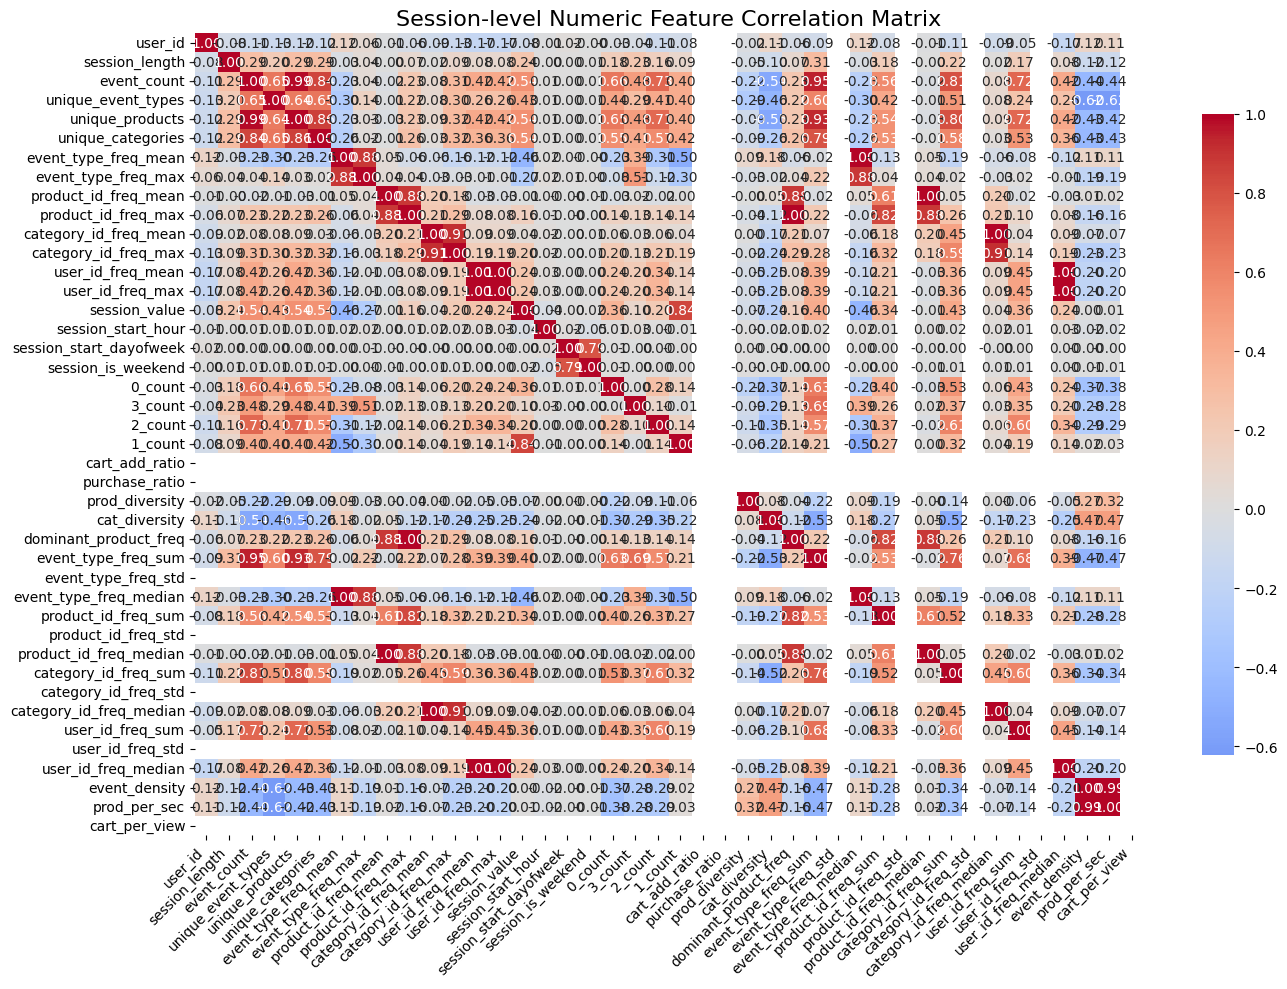

In [42]:
# %% [code]
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Select only numeric columns
numeric_cols = train_fe.select_dtypes(include=np.number)

# Replace inf/-inf with NaN, then drop NaNs
numeric_cols = numeric_cols.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='any')

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Get correlation with target
target_corr = corr_matrix["session_value"].sort_values(ascending=False)

# Split correlations into high (>0.5) and low (<0.5) absolute correlation
high_corr = target_corr[target_corr.abs() >= 0.4]
low_corr = target_corr[target_corr.abs() < 0.4]

# Save low correlations separately
low_corr.to_csv("low_correlations.csv")  # saves to CSV

# Print top correlations
print("High correlations (|corr| >= 0.4):\n", high_corr)
print("\nLow correlations (|corr| < 0.4) saved to 'low_correlations.csv'")

# Plot heatmap with better readability
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, cbar_kws={"shrink":0.8})
plt.title("Session-level Numeric Feature Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Columns kept (|corr| >= 0.5):
 ['session_value', '1_count', 'unique_products', 'event_count', 'unique_categories', 'unique_event_types', 'category_id_freq_sum', 'event_type_freq_sum', 'event_type_freq_median', 'event_type_freq_mean']


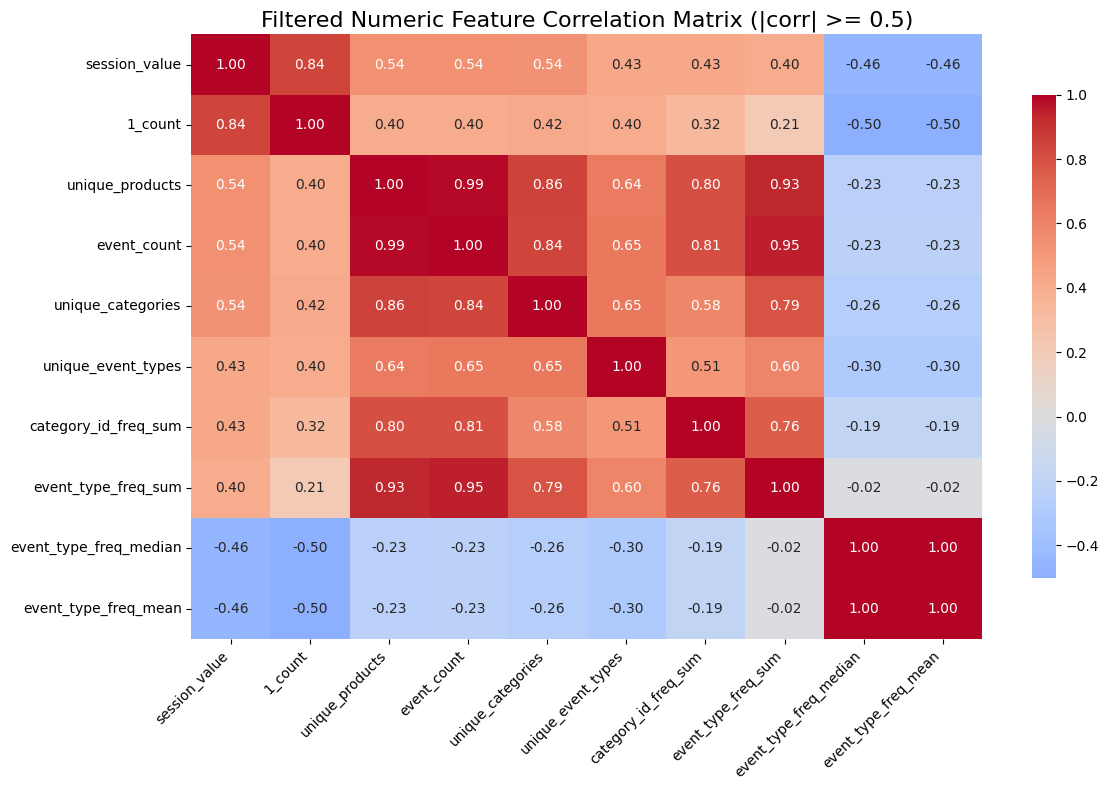

In [43]:
# %% [code]
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Select only numeric columns
numeric_cols = train_fe.select_dtypes(include=np.number)

# Replace inf/-inf with NaN, then drop NaNs
numeric_cols = numeric_cols.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='any')

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Get correlation with target
target_corr = corr_matrix["session_value"].sort_values(ascending=False)

# Keep only columns with |corr| >= 0.5
high_corr_cols = target_corr[target_corr.abs() >= 0.4].index.tolist()

# Filter train_fe
train_fe_filtered = train_fe[high_corr_cols]

# Print filtered columns
print("Columns kept (|corr| >= 0.5):\n", high_corr_cols)

# Recompute correlation matrix on filtered data
filtered_corr_matrix = train_fe_filtered.corr()

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, cbar_kws={"shrink":0.8})
plt.title("Filtered Numeric Feature Correlation Matrix (|corr| >= 0.5)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [46]:
# %% [code]
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# 1️⃣ Split data
X = train_fe_filtered.drop("session_value", axis=1)
y = train_fe_filtered["session_value"]

# Random split; stratify yok çünkü regresyon
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# %% [code]
# 2️⃣ Define models and parameter grids

# RandomForest
rf = RandomForestRegressor(random_state=42)
rf_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [1.0, "sqrt"]  # 'auto' yerine 1.0
}


# XGBoost
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1],
    "colsample_bytree": [0.7, 0.8, 1]
}

# LightGBM
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [-1, 10, 20],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [31, 50, 100],
    "subsample": [0.7, 0.8, 1]
}


In [48]:
# %% [code]
# 3️⃣ RandomizedSearchCV function
def randomized_search(model, params, X_train, y_train, n_iter=10):
    search = RandomizedSearchCV(model, params, n_iter=n_iter, cv=3, scoring="neg_root_mean_squared_error", random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    return search

# %% [code]
# Train models
rf_search = randomized_search(rf, rf_params, X_train, y_train)
xgb_search = randomized_search(xgb_model, xgb_params, X_train, y_train)
lgb_search = randomized_search(lgb_model, lgb_params, X_train, y_train)

# %% [code]
# Evaluate on validation set
models = {"RandomForest": rf_search, "XGBoost": xgb_search, "LightGBM": lgb_search}

for name, model in models.items():
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mse = mean_squared_error(y_val, y_pred, squared=True)
    print(f"{name} RMSE on validation set: {rmse:.4f}")
    print(f"{name} MSE on validation set: {mse:.4f}")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [49]:
# %% [code]
# Assume train_fe_filtered is your final training set

# 1️⃣ Sort columns alphabetically (optional, sadece düzen için)
train_fe_final = train_fe_filtered.sort_index(axis=1)

# 2️⃣ Align test set with training set
# Assume your test set is called test_fe
# Keep only columns that exist in training set
test_fe_aligned = test_fe.reindex(columns=train_fe_final.columns, fill_value=0)

# 3️⃣ Check difference
extra_cols = set(test_fe_aligned.columns) - set(train_fe_final.columns)
print("Extra columns in test set (should be empty now):", extra_cols)

# 4️⃣ Optional: check shapes
print("Training set shape:", train_fe_final.shape)
print("Test set shape:", test_fe_aligned.shape)


Extra columns in test set (should be empty now): set()
Training set shape: (70736, 10)
Test set shape: (30789, 10)


In [51]:
# %% [code]
# Make sure train and test have exactly the same columns
# Exclude target from train columns
train_cols = train_fe_final.drop("session_value", axis=1).columns

# Reindex test set to match train columns
test_fe_aligned = test_fe.reindex(columns=train_cols, fill_value=0)

# Check shapes
print("Training features shape:", train_fe_final[train_cols].shape)
print("Test features shape:", test_fe_aligned.shape)

# Predict again
y_test_pred = best_model.predict(test_fe_aligned)

# Prepare submission
submission = pd.DataFrame({
    "user_session": test_fe["user_session"],  # test setinde varsa
    "user_value": y_test_pred
})

submission.to_csv("submission.csv", index=False)
print("Submission file saved as 'submission.csv'")


Training features shape: (70736, 9)
Test features shape: (30789, 9)
Submission file saved as 'submission.csv'


In [53]:
submission.head
submission.to_csv("submission.csv", index=False)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 